Model Epoch 0: Loss = 0.1622
Model Epoch 10: Loss = 0.0657
Model Epoch 20: Loss = 0.0356
Model Epoch 30: Loss = 0.0169
Model Epoch 40: Loss = 0.0085
Using cuda device
✅ Episode Reward: -1561.54
✅ Episode Reward: -1415.68
✅ Episode Reward: -1473.07
✅ Episode Reward: -1372.71
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.46e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 230       |
|    time_elapsed    | 3         |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 2.66      |
|    critic_loss     | 4.11      |
|    ent_coef        | 0.812     |
|    ent_coef_loss   | -0.344    |
|    learning_rate   | 0.0003    |
|    n_updates       | 699       |
----------------------------------
✅ Episode Reward: -999.07
✅ Episode Reward: -1791.07
✅ Episode Reward: -905.13
✅ Episode Reward: -1067.25
------------------------

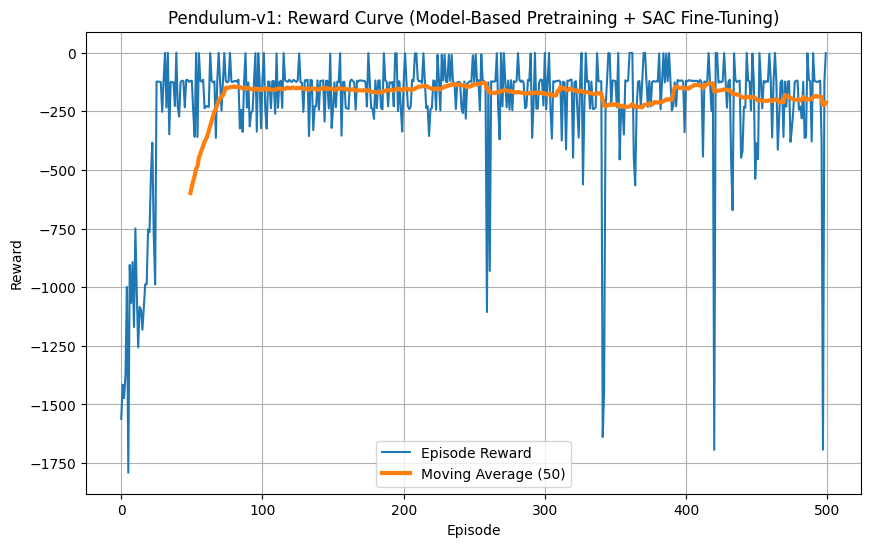

In [6]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
import gymnasium_robotics

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Step 1: Dynamics Model ====
class DynamicsModel(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(obs_dim + act_dim, 128),
            nn.ReLU(),
            nn.Linear(128, obs_dim)
        )

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=1)
        return self.model(x)

# ==== Step 2: Collect initial real experience ====
def collect_real_data(env, episodes=20):
    real_data = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()
            next_obs, _, terminated, truncated, _ = env.step(action)
            real_data.append((obs, action, next_obs))
            obs = next_obs
            done = terminated or truncated
    return real_data

# ==== Step 3: Train Dynamics Model ====
def train_dynamics_model(model, real_data, epochs=50):
    obs_t = torch.tensor([o for (o, a, n) in real_data], dtype=torch.float32).to(device)
    act_t = torch.tensor([a for (o, a, n) in real_data], dtype=torch.float32).to(device)
    next_obs_t = torch.tensor([n for (o, a, n) in real_data], dtype=torch.float32).to(device)
    delta_t = next_obs_t - obs_t

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        pred_delta = model(obs_t, act_t)
        loss = nn.MSELoss()(pred_delta, delta_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Model Epoch {epoch}: Loss = {loss.item():.4f}")

# ==== Step 4: Generate synthetic rollouts using learned policy ====
def generate_model_rollouts(model, policy, env, num_trajectories=50, horizon=15):
    model_data = []
    for _ in range(num_trajectories):
        obs, _ = env.reset()
        for _ in range(horizon):
            # Use policy action (not random)
            action, _ = policy.predict(obs, deterministic=False)
            action = np.clip(action, env.action_space.low, env.action_space.high)

            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
            action_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                delta = model(obs_tensor, action_tensor).squeeze(0).cpu().numpy()
            
            # Check for invalid delta
            if np.any(np.isnan(delta)) or np.any(np.isinf(delta)):
                print("⚠️ Skipping invalid model prediction (NaN/Inf).")
                break

            # Clip delta to avoid divergence (optional safety)
            delta = np.clip(delta, -1.0, 1.0)

            next_obs = obs + delta
            model_data.append((obs, action, next_obs))
            obs = next_obs
    return model_data

# ==== Step 5: Prepare SAC environment and data ====
def convert_to_buffer_format(data):
    obs = np.array([d[0] for d in data])
    acts = np.array([d[1] for d in data])
    next_obs = np.array([d[2] for d in data])
    rewards = np.array([-np.sum(np.square(a)) for a in acts], dtype=np.float32)  # Approximate reward
    dones = np.zeros(len(rewards), dtype=np.float32)
    return obs, acts, rewards, next_obs, dones

# ==== Reward Logging Callback ====
class RewardPrinterCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        for info in infos:
            if "episode" in info:
                ep_rew = info["episode"]["r"]
                self.episode_rewards.append(ep_rew)
                print(f"✅ Episode Reward: {ep_rew:.2f}")
        return True

# ==== Main Training Loop ====
def main():
    env = gym.make("Pendulum-v1", render_mode="human")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    # Step 1: Collect initial real experience
    real_data = collect_real_data(env)
    model = DynamicsModel(obs_dim, act_dim).to(device)
    train_dynamics_model(model, real_data)

    # Step 2: Create SAC agent (policy will be used for rollouts)
    sac_env = make_vec_env("Pendulum-v1", n_envs=1)
    model_free_agent = SAC("MlpPolicy", sac_env, verbose=1)

    # Step 3: Generate synthetic data using SAC's (random policy initially)
    synthetic_data = generate_model_rollouts(model, model_free_agent.policy, env, num_trajectories=100, horizon=15)
    all_data = real_data + synthetic_data

    if len(all_data) == 0:
        raise ValueError("No data collected! Check rollout generation.")

    # Step 4: Pre-fill replay buffer
    obs, acts, rews, next_obs, dones = convert_to_buffer_format(all_data)
    for i in range(len(obs)):
        model_free_agent.replay_buffer.add(
            obs=obs[i],
            action=acts[i],
            reward=float(rews[i]),
            next_obs=next_obs[i],
            done=float(dones[i]),
            infos=[{}]
        )

    # Step 5: Fine-tune SAC
    callback = RewardPrinterCallback()
    model_free_agent.learn(total_timesteps=100_000, callback=callback)

    # Save trained model
    model_free_agent.save("sac_pendulum_model_based")

    # ==== Step 6: Plot Reward Curve ====
    plt.figure(figsize=(10, 6))
    rewards = callback.episode_rewards
    plt.plot(rewards, label="Episode Reward")
    if len(rewards) >= 50:
        moving_avg = np.convolve(rewards, np.ones(50)/50, mode="valid")
        plt.plot(np.arange(49, len(rewards)), moving_avg, label="Moving Average (50)", linewidth=3)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Pendulum-v1: Reward Curve (Model-Based Pretraining + SAC Fine-Tuning)")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


Model Epoch 0: Loss = 0.4524
Model Epoch 10: Loss = 0.1264
Model Epoch 20: Loss = 0.0860
Model Epoch 30: Loss = 0.0471
Model Epoch 40: Loss = 0.0256
Model Epoch 50: Loss = 0.0148
Model Epoch 60: Loss = 0.0089
Model Epoch 70: Loss = 0.0062
Model Epoch 80: Loss = 0.0048
Model Epoch 90: Loss = 0.0039
Using cuda device
♻️ Regenerating model rollouts and refilling buffer...
✅ Buffer refilled with 5000 samples.

🚀 Iteration 1/5 — training...
✅ Episode Reward: -1216.58
✅ Episode Reward: -1489.48
✅ Episode Reward: -1739.56
✅ Episode Reward: -1731.31
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.54e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 232       |
|    time_elapsed    | 3         |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 2.49      |
|    critic_loss     | 4.01      |
|    ent_coef        | 0.811    

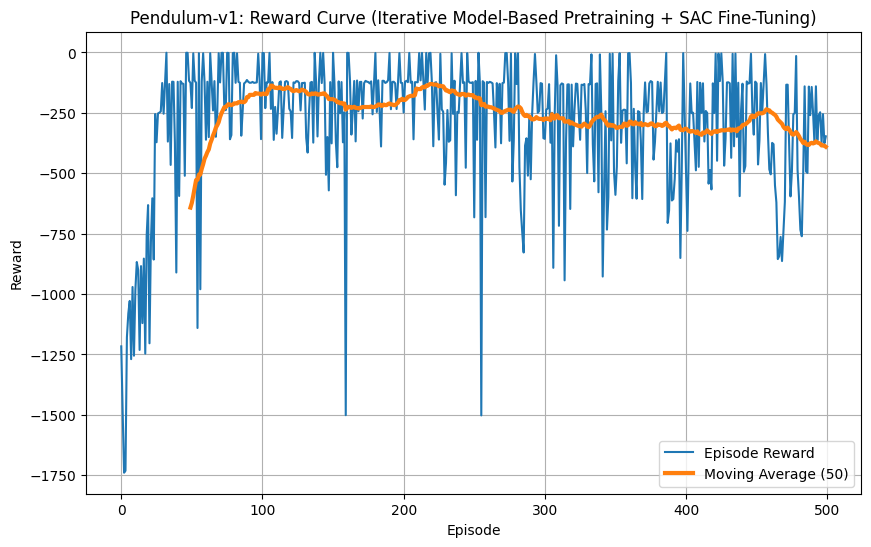

In [7]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
import gymnasium_robotics

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Step 1: Dynamics Model ====
class DynamicsModel(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(obs_dim + act_dim, 128),
            nn.ReLU(),
            nn.Linear(128, obs_dim)
        )

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=1)
        return self.model(x)

# ==== Step 2: Collect initial real experience ====
def collect_real_data(env, episodes=20):
    real_data = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()
            next_obs, _, terminated, truncated, _ = env.step(action)
            real_data.append((obs, action, next_obs))
            obs = next_obs
            done = terminated or truncated
    return real_data

# ==== Step 3: Train Dynamics Model ====
def train_dynamics_model(model, real_data, epochs=100):
    obs_t = torch.tensor([o for (o, a, n) in real_data], dtype=torch.float32).to(device)
    act_t = torch.tensor([a for (o, a, n) in real_data], dtype=torch.float32).to(device)
    next_obs_t = torch.tensor([n for (o, a, n) in real_data], dtype=torch.float32).to(device)
    delta_t = next_obs_t - obs_t

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        pred_delta = model(obs_t, act_t)
        loss = nn.MSELoss()(pred_delta, delta_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Model Epoch {epoch}: Loss = {loss.item():.4f}")

# ==== Step 4: Generate synthetic rollouts using SAC policy ====
def generate_model_rollouts(model, policy, env, num_trajectories=100, horizon=10):
    model_data = []
    for _ in range(num_trajectories):
        obs, _ = env.reset()
        for _ in range(horizon):
            action, _ = policy.predict(obs, deterministic=False)
            action = np.clip(action, env.action_space.low, env.action_space.high)

            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
            action_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                delta = model(obs_tensor, action_tensor).squeeze(0).cpu().numpy()

            if np.any(np.isnan(delta)) or np.any(np.isinf(delta)):
                print("⚠️ Skipping invalid model prediction (NaN/Inf).")
                break

            delta = np.clip(delta, -1.0, 1.0)
            next_obs = obs + delta
            model_data.append((obs, action, next_obs))
            obs = next_obs
    return model_data

# ==== Step 5: Convert data to replay buffer format ====
def convert_to_buffer_format(data):
    obs = np.array([d[0] for d in data])
    acts = np.array([d[1] for d in data])
    next_obs = np.array([d[2] for d in data])
    rewards = np.array([-np.sum(np.square(a)) for a in acts], dtype=np.float32)
    dones = np.zeros(len(rewards), dtype=np.float32)
    return obs, acts, rewards, next_obs, dones

# ==== Callback for rewards logging ====
class RewardPrinterCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        for info in infos:
            if "episode" in info:
                ep_rew = info["episode"]["r"]
                self.episode_rewards.append(ep_rew)
                print(f"✅ Episode Reward: {ep_rew:.2f}")
        return True

# ==== Function to refill buffer with new synthetic rollouts ====
def refill_replay_buffer(agent, model, policy, env, real_data, synthetic_rollouts=100):
    print("♻️ Regenerating model rollouts and refilling buffer...")
    synthetic_data = generate_model_rollouts(model, policy, env, num_trajectories=synthetic_rollouts, horizon=10)
    all_data = real_data + synthetic_data

    obs, acts, rews, next_obs, dones = convert_to_buffer_format(all_data)

    agent.replay_buffer.reset()  # Clear old buffer

    for i in range(len(obs)):
        agent.replay_buffer.add(
            obs=obs[i],
            action=acts[i],
            reward=float(rews[i]),
            next_obs=next_obs[i],
            done=float(dones[i]),
            infos=[{}]
        )
    print(f"✅ Buffer refilled with {len(obs)} samples.")

# ==== Main Training Loop ====
def main():
    env = gym.make("Pendulum-v1", render_mode="human")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    # Step 1: Collect initial real experience
    real_data = collect_real_data(env)
    model = DynamicsModel(obs_dim, act_dim).to(device)
    train_dynamics_model(model, real_data)

    # Step 2: Create SAC agent
    sac_env = make_vec_env("Pendulum-v1", n_envs=1)
    model_free_agent = SAC("MlpPolicy", sac_env, verbose=1, learning_rate=3e-4, batch_size=256)

    # Step 3: Initial synthetic rollout and buffer fill
    refill_replay_buffer(model_free_agent, model, model_free_agent.policy, env, real_data, synthetic_rollouts=100)

    callback = RewardPrinterCallback()

    total_steps = 100_000
    rollout_every_steps = 20_000
    steps_per_iteration = rollout_every_steps

    num_iterations = total_steps // steps_per_iteration

    for iteration in range(num_iterations):
        print(f"\n🚀 Iteration {iteration+1}/{num_iterations} — training...")
        model_free_agent.learn(total_timesteps=steps_per_iteration, reset_num_timesteps=False, callback=callback)

        # After training for rollout_every_steps, refresh model rollouts
        refill_replay_buffer(model_free_agent, model, model_free_agent.policy, env, real_data, synthetic_rollouts=100)

    model_free_agent.save("sac_pendulum_iterative_model_based")

    # Plot rewards
    plt.figure(figsize=(10, 6))
    rewards = callback.episode_rewards
    plt.plot(rewards, label="Episode Reward")
    if len(rewards) >= 50:
        moving_avg = np.convolve(rewards, np.ones(50)/50, mode="valid")
        plt.plot(np.arange(49, len(rewards)), moving_avg, label="Moving Average (50)", linewidth=3)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Pendulum-v1: Reward Curve (Iterative Model-Based Pretraining + SAC Fine-Tuning)")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


Model Epoch 0: Loss = 0.2389
Model Epoch 10: Loss = 0.0913
Model Epoch 20: Loss = 0.0548
Model Epoch 30: Loss = 0.0333
Model Epoch 40: Loss = 0.0173
Model Epoch 50: Loss = 0.0092
Model Epoch 60: Loss = 0.0052
Model Epoch 70: Loss = 0.0035
Model Epoch 80: Loss = 0.0029
Model Epoch 90: Loss = 0.0025
Using cuda device
♻️ Regenerating model rollouts and refilling buffer...


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x155552a91bb0>>)
Traceback (most recent call last):
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/jupyter_client/session.py", line 99, in json_packer
    return json.dumps(
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 68-69: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/ipykernel/iostream.py", line 649, in _flush
    self.session.send(
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/jupyter_client/session.py", line 844, in send
    to_send = self.serialize(msg, ident)
  File "/

✅ Episode Reward: -1264.34
✅ Episode Reward: -1085.08
✅ Episode Reward: -1173.30
✅ Episode Reward: -875.86
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -1.1e+03 |
| time/              |          |
|    episodes        | 4        |
|    fps             | 233      |
|    time_elapsed    | 3        |
|    total_timesteps | 800      |
| train/             |          |
|    actor_loss      | 2.56     |
|    critic_loss     | 4.3      |
|    ent_coef        | 0.812    |
|    ent_coef_loss   | -0.337   |
|    learning_rate   | 0.0003   |
|    n_updates       | 699      |
---------------------------------
✅ Episode Reward: -1639.43
✅ Episode Reward: -1287.08
✅ Episode Reward: -1666.17
✅ Episode Reward: -1615.22
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.33e+03 |
| time/              |           |
|    episodes        | 8        

ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x155552a91bb0>>)
Traceback (most recent call last):
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/jupyter_client/session.py", line 99, in json_packer
    return json.dumps(
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 68-69: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/ipykernel/iostream.py", line 649, in _flush
    self.session.send(
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/jupyter_client/session.py", line 844, in send
    to_send = self.serialize(msg, ident)
  File "/

✅ Episode Reward: -228.94
✅ Episode Reward: -117.74
✅ Episode Reward: -227.43
✅ Episode Reward: -239.80
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -381     |
| time/              |          |
|    episodes        | 104      |
|    fps             | 207      |
|    time_elapsed    | 3        |
|    total_timesteps | 20800    |
| train/             |          |
|    actor_loss      | 85.6     |
|    critic_loss     | 3.1      |
|    ent_coef        | 0.108    |
|    ent_coef_loss   | -0.223   |
|    learning_rate   | 0.0003   |
|    n_updates       | 20699    |
---------------------------------
✅ Episode Reward: -119.04
✅ Episode Reward: -117.80
✅ Episode Reward: -127.48
✅ Episode Reward: -119.32
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -324     |
| time/              |          |
|    episodes        | 108      |
|    fps  

ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x155552a91bb0>>)
Traceback (most recent call last):
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/jupyter_client/session.py", line 99, in json_packer
    return json.dumps(
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 68-69: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/ipykernel/iostream.py", line 649, in _flush
    self.session.send(
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/jupyter_client/session.py", line 844, in send
    to_send = self.serialize(msg, ident)
  File "/

✅ Episode Reward: -0.86
✅ Episode Reward: -116.29
✅ Episode Reward: -122.48
✅ Episode Reward: -1.70
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -177     |
| time/              |          |
|    episodes        | 204      |
|    fps             | 205      |
|    time_elapsed    | 3        |
|    total_timesteps | 40800    |
| train/             |          |
|    actor_loss      | 76.4     |
|    critic_loss     | 1.89     |
|    ent_coef        | 0.0585   |
|    ent_coef_loss   | 1.26     |
|    learning_rate   | 0.0003   |
|    n_updates       | 40699    |
---------------------------------
✅ Episode Reward: -966.88
✅ Episode Reward: -239.04
✅ Episode Reward: -125.46
✅ Episode Reward: -565.99
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -191     |
| time/              |          |
|    episodes        | 208      |
|    fps      

ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x155552a91bb0>>)
Traceback (most recent call last):
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/jupyter_client/session.py", line 99, in json_packer
    return json.dumps(
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 68-69: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/ipykernel/iostream.py", line 649, in _flush
    self.session.send(
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/jupyter_client/session.py", line 844, in send
    to_send = self.serialize(msg, ident)
  File "/

✅ Episode Reward: -120.50
✅ Episode Reward: -121.69
✅ Episode Reward: -1.17
✅ Episode Reward: -130.58
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -234     |
| time/              |          |
|    episodes        | 304      |
|    fps             | 206      |
|    time_elapsed    | 3        |
|    total_timesteps | 60800    |
| train/             |          |
|    actor_loss      | 86.1     |
|    critic_loss     | 1.95     |
|    ent_coef        | 0.079    |
|    ent_coef_loss   | 0.62     |
|    learning_rate   | 0.0003   |
|    n_updates       | 60699    |
---------------------------------
✅ Episode Reward: -128.72
✅ Episode Reward: -306.04
✅ Episode Reward: -122.08
✅ Episode Reward: -2.78
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -220     |
| time/              |          |
|    episodes        | 308      |
|    fps      

ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x155552a91bb0>>)
Traceback (most recent call last):
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/jupyter_client/session.py", line 99, in json_packer
    return json.dumps(
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 68-69: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/ipykernel/iostream.py", line 649, in _flush
    self.session.send(
  File "/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/jupyter_client/session.py", line 844, in send
    to_send = self.serialize(msg, ident)
  File "/

✅ Episode Reward: -249.04
✅ Episode Reward: -122.94
✅ Episode Reward: -245.78
✅ Episode Reward: -120.83
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 404      |
|    fps             | 206      |
|    time_elapsed    | 3        |
|    total_timesteps | 80800    |
| train/             |          |
|    actor_loss      | 85       |
|    critic_loss     | 1.28     |
|    ent_coef        | 0.045    |
|    ent_coef_loss   | 1.8      |
|    learning_rate   | 0.0003   |
|    n_updates       | 80699    |
---------------------------------
✅ Episode Reward: -121.60
✅ Episode Reward: -121.77
✅ Episode Reward: -122.02
✅ Episode Reward: -236.53
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 408      |
|    fps  

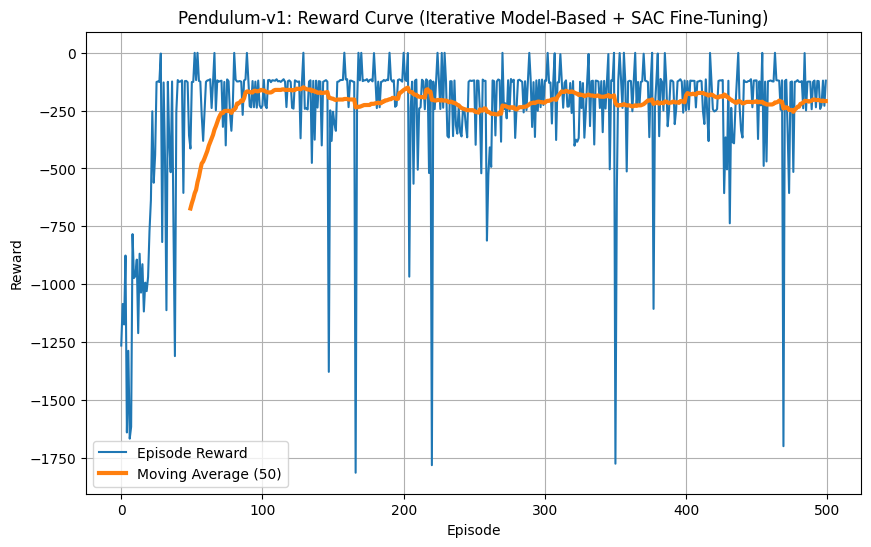

In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
import gymnasium_robotics

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Dynamics Model ====
class DynamicsModel(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(obs_dim + act_dim, 128),
            nn.ReLU(),
            nn.Linear(128, obs_dim)
        )

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=1)
        return self.model(x)

# ==== Collect real experience ====
def collect_real_data(env, episodes=20):
    real_data = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()
            next_obs, _, terminated, truncated, _ = env.step(action)
            real_data.append((obs, action, next_obs))
            obs = next_obs
            done = terminated or truncated
    return real_data

# ==== Train Dynamics Model ====
def train_dynamics_model(model, real_data, epochs=100):
    obs_t = torch.tensor([o for (o, a, n) in real_data], dtype=torch.float32).to(device)
    act_t = torch.tensor([a for (o, a, n) in real_data], dtype=torch.float32).to(device)
    next_obs_t = torch.tensor([n for (o, a, n) in real_data], dtype=torch.float32).to(device)
    delta_t = next_obs_t - obs_t

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        pred_delta = model(obs_t, act_t)
        loss = nn.MSELoss()(pred_delta, delta_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Model Epoch {epoch}: Loss = {loss.item():.4f}")

# ==== Generate synthetic rollouts ====
def generate_model_rollouts(model, policy, env, num_trajectories=100, horizon=10):
    model_data = []
    for _ in range(num_trajectories):
        obs, _ = env.reset()
        for _ in range(horizon):
            action, _ = policy.predict(obs, deterministic=False)
            action = np.clip(action, env.action_space.low, env.action_space.high)

            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
            action_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                delta = model(obs_tensor, action_tensor).squeeze(0).cpu().numpy()

            if np.any(np.isnan(delta)) or np.any(np.isinf(delta)):
                print("\u26a0\ufe0f Skipping invalid model prediction (NaN/Inf).")
                break

            delta = np.clip(delta, -1.0, 1.0)
            next_obs = obs + delta
            model_data.append((obs, action, next_obs))
            obs = next_obs
    return model_data

# ==== Convert to buffer format ====
def convert_to_buffer_format(data):
    obs = np.array([d[0] for d in data])
    acts = np.array([d[1] for d in data])
    next_obs = np.array([d[2] for d in data])
    rewards = np.array([-np.sum(np.square(a)) for a in acts], dtype=np.float32)
    dones = np.zeros(len(rewards), dtype=np.float32)
    return obs, acts, rewards, next_obs, dones

# ==== Reward Logging Callback ====
class RewardPrinterCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        for info in infos:
            if "episode" in info:
                ep_rew = info["episode"]["r"]
                self.episode_rewards.append(ep_rew)
                print(f"\u2705 Episode Reward: {ep_rew:.2f}")
        return True

# ==== Refill Replay Buffer ====
def refill_replay_buffer(agent, model, policy, env, real_data, synthetic_rollouts=100):
    print("\u267b\ufe0f Regenerating model rollouts and refilling buffer...")
    synthetic_data = generate_model_rollouts(model, policy, env, num_trajectories=synthetic_rollouts, horizon=10)
    all_data = real_data + synthetic_data

    obs, acts, rews, next_obs, dones = convert_to_buffer_format(all_data)
    agent.replay_buffer.reset()

    for i in range(len(obs)):
        agent.replay_buffer.add(
            obs=obs[i],
            action=acts[i],
            reward=float(rews[i]),
            next_obs=next_obs[i],
            done=float(dones[i]),
            infos=[{}]
        )
    print(f"\u2705 Buffer refilled with {len(obs)} samples.")

# ==== Main Loop ====
def main():
    env = gym.make("Pendulum-v1", render_mode="human")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    real_data = collect_real_data(env)
    model = DynamicsModel(obs_dim, act_dim).to(device)
    train_dynamics_model(model, real_data)

    sac_env = make_vec_env("Pendulum-v1", n_envs=1)
    model_free_agent = SAC("MlpPolicy", sac_env, verbose=1, learning_rate=3e-4, batch_size=256)

    refill_replay_buffer(model_free_agent, model, model_free_agent.policy, env, real_data, synthetic_rollouts=100)
    callback = RewardPrinterCallback()

    total_steps = 100_000
    rollout_every_steps = 20_000
    steps_per_iteration = rollout_every_steps
    num_iterations = total_steps // steps_per_iteration

    for iteration in range(num_iterations):
        print(f"\n\ud83d\ude80 Iteration {iteration+1}/{num_iterations} — training...")

        # 1. Fine-tune SAC
        model_free_agent.learn(total_timesteps=steps_per_iteration, reset_num_timesteps=False, callback=callback)

        # 2. Retrain dynamics model
        train_dynamics_model(model, real_data, epochs=100)

        # 3. Refresh buffer
        refill_replay_buffer(model_free_agent, model, model_free_agent.policy, env, real_data, synthetic_rollouts=100)

    model_free_agent.save("sac_pendulum_iterative_model_based")

    # Plot rewards
    plt.figure(figsize=(10, 6))
    rewards = callback.episode_rewards
    plt.plot(rewards, label="Episode Reward")
    if len(rewards) >= 50:
        moving_avg = np.convolve(rewards, np.ones(50)/50, mode="valid")
        plt.plot(np.arange(49, len(rewards)), moving_avg, label="Moving Average (50)", linewidth=3)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Pendulum-v1: Reward Curve (Iterative Model-Based + SAC Fine-Tuning)")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


In [4]:
import gymnasium as gym
import numpy as np
import time
import imageio
from stable_baselines3 import SAC

# === Settings ===
EPISODES_TO_RUN = 3
STEPS_PER_EPISODE = 200
VIDEO_PATH = "pendulum_demo.mp4"
RECORD_VIDEO = True  # Set to False if you only want live rendering

# === Load trained model ===
env = gym.make("Pendulum-v1", render_mode="rgb_array" if RECORD_VIDEO else "human")
model = SAC.load("sac_pendulum_iterative_model_based", env=env)

# === Initialize video writer ===
frames = []

for ep in range(EPISODES_TO_RUN):
    obs, _ = env.reset()
    total_reward = 0
    for step in range(STEPS_PER_EPISODE):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        if RECORD_VIDEO:
            frame = env.render()
            frames.append(frame)
        else:
            env.render()
            time.sleep(0.02)

        if terminated or truncated:
            break

    print(f"✅ Episode {ep+1} Reward: {total_reward:.2f}")

env.close()

# === Save video ===
if RECORD_VIDEO:
    print(f"🎥 Saving video to {VIDEO_PATH} ...")
    imageio.mimsave(VIDEO_PATH, frames, fps=30)
    print("✅ Video saved.")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


error: XDG_RUNTIME_DIR is invalid or not set in the environment.


✅ Episode 1 Reward: -125.51
✅ Episode 2 Reward: -118.74
✅ Episode 3 Reward: -122.59
🎥 Saving video to pendulum_demo.mp4 ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x551de80] Warning: data is not aligned! This can lead to a speed loss


✅ Video saved.


HALF CHEETAH Down:

2025-04-29 15:17:09.119849: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 15:17:09.121316: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 15:17:09.152804: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-29 15:17:12.805187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/

Model Epoch 0: Loss = 34.3366
Model Epoch 10: Loss = 23.6754
Model Epoch 20: Loss = 17.1591
Model Epoch 30: Loss = 13.9988
Model Epoch 40: Loss = 13.0029
Model Epoch 50: Loss = 12.5534
Model Epoch 60: Loss = 12.0755
Model Epoch 70: Loss = 11.6065
Model Epoch 80: Loss = 11.1447
Model Epoch 90: Loss = 10.6591
Model Epoch 100: Loss = 10.1419
Model Epoch 110: Loss = 9.5892
Model Epoch 120: Loss = 9.0001
Model Epoch 130: Loss = 8.3772
Model Epoch 140: Loss = 7.7269
Model Epoch 150: Loss = 7.0595
Model Epoch 160: Loss = 6.3892
Model Epoch 170: Loss = 5.7326
Model Epoch 180: Loss = 5.1073
Model Epoch 190: Loss = 4.5288
Using cuda device
♻️ Regenerating model rollouts and refilling buffer...


/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


✅ Buffer refilled with 51000 samples.

🚀 Iteration 1/5 — training...
✅ Episode Reward: -150.17
✅ Episode Reward: -208.10
✅ Episode Reward: -286.02
✅ Episode Reward: -162.19
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 205      |
|    time_elapsed    | 19       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -33.4    |
|    critic_loss     | 1.63     |
|    ent_coef        | 0.313    |
|    ent_coef_loss   | -11.1    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3899     |
---------------------------------
✅ Episode Reward: -200.35
✅ Episode Reward: -202.91
✅ Episode Reward: -178.83
✅ Episode Reward: -95.98
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -186     |
| time/   

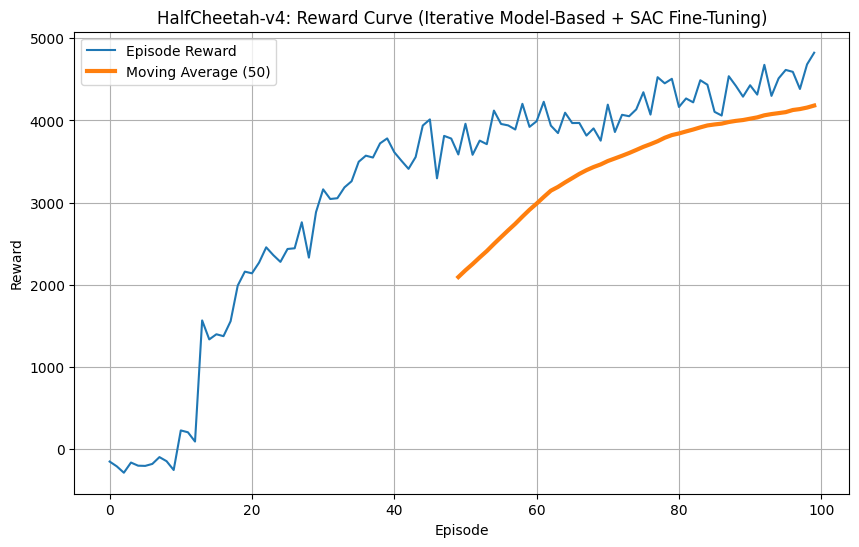

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
import gymnasium_robotics

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Dynamics Model ====
class DynamicsModel(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(obs_dim + act_dim, 512),
            nn.ReLU(),
            nn.Linear(512, obs_dim)
        )

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=1)
        return self.model(x)

# ==== Collect real experience ====
def collect_real_data(env, episodes=50):
    real_data = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()
            next_obs, reward, terminated, truncated, _ = env.step(action)
            real_data.append((obs, action, next_obs, reward))
            obs = next_obs
            done = terminated or truncated
    return real_data

# ==== Train Dynamics Model ====
def train_dynamics_model(model, real_data, epochs=200):
    obs_t = torch.tensor([o for (o, a, n, r) in real_data], dtype=torch.float32).to(device)
    act_t = torch.tensor([a for (o, a, n, r) in real_data], dtype=torch.float32).to(device)
    next_obs_t = torch.tensor([n for (o, a, n, r) in real_data], dtype=torch.float32).to(device)
    delta_t = next_obs_t - obs_t

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        pred_delta = model(obs_t, act_t)
        loss = nn.MSELoss()(pred_delta, delta_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Model Epoch {epoch}: Loss = {loss.item():.4f}")

# ==== Generate synthetic rollouts ====
def generate_model_rollouts(model, policy, env, num_trajectories=100, horizon=10):
    model_data = []
    for _ in range(num_trajectories):
        obs, _ = env.reset()
        for _ in range(horizon):
            action, _ = policy.predict(obs, deterministic=False)
            action = np.clip(action, env.action_space.low, env.action_space.high)

            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
            action_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                delta = model(obs_tensor, action_tensor).squeeze(0).cpu().numpy()

            if np.any(np.isnan(delta)) or np.any(np.isinf(delta)):
                print("⚠️ Skipping invalid model prediction (NaN/Inf).")
                break

            delta = np.clip(delta, -1.0, 1.0)
            next_obs = obs + delta
            reward = next_obs[0]  # crude forward velocity approx
            model_data.append((obs, action, next_obs, reward))
            obs = next_obs
    return model_data

# ==== Convert to buffer format ====
def convert_to_buffer_format(data):
    obs = np.array([d[0] for d in data])
    acts = np.array([d[1] for d in data])
    next_obs = np.array([d[2] for d in data])
    rewards = np.array([d[3] for d in data], dtype=np.float32)
    dones = np.zeros(len(rewards), dtype=np.float32)
    return obs, acts, rewards, next_obs, dones

# ==== Reward Logging Callback ====
class RewardPrinterCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        for info in infos:
            if "episode" in info:
                ep_rew = info["episode"]["r"]
                self.episode_rewards.append(ep_rew)
                print(f"✅ Episode Reward: {ep_rew:.2f}")
        return True

# ==== Refill Replay Buffer ====
def refill_replay_buffer(agent, model, policy, env, real_data, synthetic_rollouts=100):
    print("♻️ Regenerating model rollouts and refilling buffer...")
    synthetic_data = generate_model_rollouts(model, policy, env, num_trajectories=synthetic_rollouts, horizon=10)
    all_data = real_data + synthetic_data

    obs, acts, rews, next_obs, dones = convert_to_buffer_format(all_data)
    agent.replay_buffer.reset()

    for i in range(len(obs)):
        agent.replay_buffer.add(
            obs=obs[i],
            action=acts[i],
            reward=float(rews[i]),
            next_obs=next_obs[i],
            done=float(dones[i]),
            infos=[{}]
        )
    print(f"✅ Buffer refilled with {len(obs)} samples.")

# ==== Main Loop ====
def main():
    env = gym.make("HalfCheetah-v4", render_mode=None)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    real_data = collect_real_data(env)
    model = DynamicsModel(obs_dim, act_dim).to(device)
    train_dynamics_model(model, real_data)

    sac_env = make_vec_env("HalfCheetah-v4", n_envs=1)
    model_free_agent = SAC("MlpPolicy", sac_env, verbose=1, learning_rate=3e-4, batch_size=512, buffer_size=1_000_000)

    refill_replay_buffer(model_free_agent, model, model_free_agent.policy, env, real_data, synthetic_rollouts=100)
    callback = RewardPrinterCallback()

    total_steps = 100_000
    rollout_every_steps = 20_000
    steps_per_iteration = rollout_every_steps
    num_iterations = total_steps // steps_per_iteration

    for iteration in range(num_iterations):
        print(f"\n🚀 Iteration {iteration+1}/{num_iterations} — training...")

        model_free_agent.learn(total_timesteps=steps_per_iteration, reset_num_timesteps=False, callback=callback)
        train_dynamics_model(model, real_data, epochs=200)
        refill_replay_buffer(model_free_agent, model, model_free_agent.policy, env, real_data, synthetic_rollouts=100)

    model_free_agent.save("sac_halfcheetah_model_based")

    plt.figure(figsize=(10, 6))
    rewards = callback.episode_rewards
    plt.plot(rewards, label="Episode Reward")
    if len(rewards) >= 50:
        moving_avg = np.convolve(rewards, np.ones(50)/50, mode="valid")
        plt.plot(np.arange(49, len(rewards)), moving_avg, label="Moving Average (50)", linewidth=3)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("HalfCheetah-v4: Reward Curve (Iterative Model-Based + SAC Fine-Tuning)")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

DEMO VIDEO SAVED DOWN:

In [3]:
import os
os.environ["MUJOCO_GL"] = "egl"

In [1]:
import os
os.environ["MUJOCO_GL"] = "osmesa"
os.environ["PYOPENGL_PLATFORM"] = "osmesa"

import gymnasium as gym
import numpy as np
import time
import imageio
from stable_baselines3 import SAC

# === Settings ===
EPISODES_TO_RUN = 3
STEPS_PER_EPISODE = 1000
VIDEO_PATH = "halfcheetah_demo.mp4"
RECORD_VIDEO = True

# === Load trained model ===
env = gym.make("HalfCheetah-v4", render_mode="rgb_array" if RECORD_VIDEO else "human")
model = SAC.load("sac_halfcheetah_model_based", env=env)

# === Frame collection for video ===
frames = []

for ep in range(EPISODES_TO_RUN):
    obs, _ = env.reset()
    total_reward = 0
    for _ in range(STEPS_PER_EPISODE):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        if RECORD_VIDEO:
            frame = env.render()
            frames.append(frame)
        else:
            env.render()
            time.sleep(0.01)  # Slow down for better viewing

        if terminated or truncated:
            break

    print(f"✅ Episode {ep+1} Reward: {total_reward:.2f}")

env.close()

# === Save video ===
if RECORD_VIDEO:
    print(f"🎥 Saving video to {VIDEO_PATH} ...")
    imageio.mimsave(VIDEO_PATH, frames, fps=30)
    print("✅ Video saved.")


2025-04-29 15:39:58.483834: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 15:39:58.485323: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 15:39:58.516822: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-29 15:40:02.004209: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/tushard/miniconda3/envs/NLPproj/lib/python3.8/site-packages/

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ Episode 1 Reward: 4851.51
✅ Episode 2 Reward: 4884.08
✅ Episode 3 Reward: 4697.69
🎥 Saving video to halfcheetah_demo.mp4 ...
✅ Video saved.
